In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import os
from astropy.io import fits
import scipy.ndimage
from astropy import units as u

from scalessim.DFT import *
from scalessim.binning import *
from scalessim.phasescreen import *
from scalessim.pupil import *
from scalessim.io import *
from scalessim.focal_plane import *
from scalessim.targs import *
from scalessim.base import *
from scalessim.helpers import *

# SCALES low-res SED example

This notebook runs through all the steps for generating a raw SCALES image using either:

(1) a target spectrum in erg/s/cm^2/um + a PSF
OR
(2) a model datacube with fluxes in erg/s/cm^2/um

You don't need to change any of the configuration stuff at the beginning if you don't want to. There are comments that describe some parameters that you might be interested in adjusting.

This example just uses PHOENIX models to set up simple stellar targets as "Target" objects. It then uses PHOENIX models to make an example model datacube that you can feed to the simulator. You can replace that with whatever scene you like, as long as the dimensions match the number of spaxels in each dimension (108 by 108), and the flux units are erg/s/cm^2/um. 

In the end it does a simple aperture extraction to generate a datacube. 

# SET UP OBSERVING MODE AND SCENE HERE

In [2]:
###Set your minimum and maximum wavelengths (in microns) here. 
###Realistic options (corresponding to planned modes) are: 2.0-5.2, 
wav_min = 2.0
wav_max = 5.2

###Set up a target spectrum to use with the SCALES PSF
T_s = 10000 #stellar temperature in K
logg = 4.5 #log surface gravity [cgs]
zz = 0.0 #metallicity 
rstar = 2.0 #stellar radius in solar radii
dstar = 100.0 #distance in pc

wav,I_lam = phoenix_star(T_s,logg,zz,rstar,dstar)

####set this up as a Target
targ = Target(wav,I_lam)

###Set up a scene instead of assuming a single point source with a spectrum
##make spectrum first
T_s = 10000 #stellar temperature in K
logg = 4.5 #log surface gravity [cgs]
zz = 0.0 #metallicity 
rstar = 2.0 #stellar radius in solar radii
dstar = 100.0 #distance in pc

wav,I_lam = phoenix_star(T_s,logg,zz,rstar,dstar)

lams_binned=np.linspace(1.9,5.3,341)
I_lam2 = spectres(lams_binned,wav,I_lam)

##create empty cube for scene
scene = np.zeros([len(lams_binned),108,108])

##central point source
scene[:,54,54] = I_lam2

##equal contrast companion
scene[:,74,74] = I_lam2


## Configure your H2RG

Load in h2rg configuration file 

In [3]:
import configparser
from detector import nghxrg as ng

config = configparser.ConfigParser()
config.read('h2rg.ini')

arg_detector = {}
arg_detector.update(read_ini(config['Defined']))

ng_h2rg = ng.HXRGNoise(verbose=False,
                        wind_mode='WINDOW',
                        naxis1=1024, naxis2=1024,
                        pca0_file='./detector/lmircam_pca0.fits')


Define some reasonable noise parameters

In [4]:
rd_noise=arg_detector['readout_noise_cds']*1.   # White read noise per integration
pedestal=arg_detector['pedestal']*1.   # DC pedestal drift rms
c_pink=arg_detector['c_pink']*1.     # Correlated pink noise
u_pink=arg_detector['u_pink']*1.     # Uncorrelated pink noise
acn=arg_detector['acn']*1.        # Correlated ACN
pca0_amp=arg_detector['pca0_amp']*1.   # Amplitude of PCA zero "picture frame" noise

#arg_detector 

## Configure SCALES mode

Read in SCALES config file for H2RG

In [5]:
config.read('scales_h2rg.ini')
arg_spaxel = {}
arg_spaxel.update(read_ini(config['Defined']))
arg_spaxel.update(read_ini(config['Derived']))
arg_spaxel.update(read_ini(config['User']))

#arg_spaxel

In [6]:
arg_spaxel['min_wavelength'] = wav_min #minimum wavelength in microns
arg_spaxel['max_wavelength'] = wav_max #maximum wavelength in microns

## Set up lenslet traces

In [7]:
lens = Lenslet(arg_spaxel)
lens.get_shifts()
lens.make_trace(phys=True)

## Read in Keck pupil

In [8]:
keck = fits.getdata('keckpupil.fits')
keck = scipy.ndimage.zoom(keck, 10, order=0)
pupil = Pupil()
pupil.pupil = keck

## Filtered phase screen for toy AO correction

Can set screen1 to zeros to leave this out

In [9]:
screen = PhaseScreen(pupil=pupil, L0=10)
screen.sr_factor = screen.set_strehl(.8, 500e-9)
screen1 = screen.get_res()
#screen1 = np.zeros(screen1.shape)

## Use pupil and residual phase to generate cube of Keck PSFs

In [10]:
nspax = arg_spaxel['no_spaxel']
nlam = lens.trace.shape[0]

keck_cube = np.zeros((nlam, nspax, nspax))
mag1 = magn(lens.lmin)
mag2 = magn(lens.lmax)

psf_file = 'keck_psf_cube_'+str(lens.lmin)+'_'+str(lens.lmax)+'_n'+str(nlam)+'.fits'
if os.path.isfile(psf_file)==False:
    for i, mag in enumerate(np.linspace(mag1, mag2, nlam)):
        W = DFT_matrix(1600, mag)
        A = pupil.pupil * np.exp(1.j * screen1)
        out = abs(W.dot(A).dot(W))**2
        out /= np.sum(out, axis=(0,1))
        keck_cube[i] = frebin(out, (108, 108))
    fits.writeto(psf_file,np.array(keck_cube),clobber=True)
else: keck_cube = pyfits.getdata(psf_file)

## Define some observational parameters

-Reads in sky transmission and emission models provided by Gemini for MK site: https://www.gemini.edu/observing/telescopes-and-sites/sites#IRSky

-Reads in atmospheric dispersion data based on relative humidity, temperature, pressure, and airmass

-Instrument transmission & emission includes SCALES + AO emissivity

-Default QE is 70%

-For now set up perfect filter with tophat from lmin to lmax

-Define single frame integration time in seconds

In [11]:
vapor = 1 #PWV in mm
airmass = 1 
skybg = SkyBG(vapor,airmass)
skytrans = SkyTrans(vapor,airmass)
atmodisp = AtmoDispersion(90,20,600)
inst_emissivities = [.08]*3 + [.01]*8
inst_temps = [273*u.K]*11
inst = InstTransEm(inst_emissivities, inst_temps)
qe = QE()
filt = Filter(lmin=lens.lmin,lmax=lens.lmax)
dit = 1 ###integration time in seconds

In [12]:
####organize all these and pass to focal_plane 
args_new = {'Lenslet_object':lens,
            'SkyBG':skybg,
            'SkyTrans':skytrans,
            'InstTransEm':inst,
            'Filter':filt,
            'QE':qe}
fp = FocalPlane(args_new)

## Generate raw SCALES frame using target + PSF

making full raw image


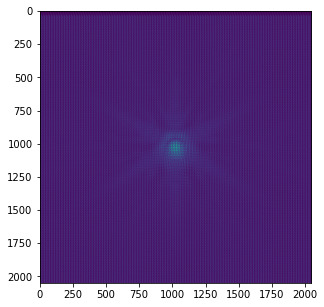

In [13]:
raw, bg_star_truth = fp.get_fp(dit*u.s,targ,return_full=True,PSF=keck_cube)
rawfile = 'raw_frame_targ.fits'
pyfits.writeto(rawfile,np.array(raw),clobber=True)

f = plt.figure(figsize=(5,5))
plt.imshow(raw**0.25)
plt.show()

## Convolve scene with PSF instead

erg2 / (cm4 micron2 s2)
[[1.27987940e-14 2.70920815e-15 2.83958928e-15 ... 1.21992572e-14
  5.10329509e-15 2.03845106e-14]
 [5.12365274e-15 1.31239166e-14 6.98523868e-15 ... 3.98884413e-15
  1.89056943e-14 2.92336777e-14]
 [5.00500446e-15 1.43917600e-14 3.52746408e-15 ... 5.18072967e-15
  2.52870415e-14 1.77311512e-14]
 ...
 [6.09994117e-15 3.93888854e-15 2.15085187e-15 ... 6.94510274e-15
  1.75626469e-15 2.71733953e-15]
 [1.29460407e-14 6.67270399e-15 1.86986279e-15 ... 3.76299153e-15
  4.67075873e-15 4.83795690e-15]
 [1.85400574e-14 5.37523753e-15 9.88320932e-16 ... 1.21877691e-14
  8.02771625e-15 9.83780847e-15]] erg2 / (cm4 micron2 s2)


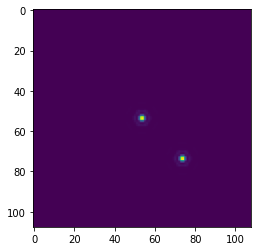

In [34]:
FT_psf = np.array([np.fft.fft2(keck_cube[i]) for i in range(len(keck_cube))])
FT_scene = np.array([np.fft.fft2(scene[i].value) for i in range(len(scene))])
FT_conv = FT_psf*FT_scene

scene_conv = np.array([np.real(np.fft.ifftshift(np.fft.ifft2(FT_conv[i]))) for i in range(len(scene))])

print(scene.unit)

print(scene_conv[0]*scene.unit)

plt.imshow(scene_conv[0])
plt.show()

## Generate a raw SCALES frame using input cube

In [30]:
scene = scene*u.erg / u.cm**2 / u.micron / u.s
raw_c, bg_star_truth = fp.get_fp(dit*u.s,cube=scene_conv,return_full=True)
rawfile = 'raw_frame_cube.fits'
pyfits.writeto(rawfile,np.array(raw_c),clobber=True)

f = plt.figure(figsize=(5,5))
plt.imshow(raw_c**0.2)
plt.show()

using cube


AttributeError: 'numpy.ndarray' object has no attribute 'to'

## Cube up raw frame using simple aperture extraction

In [ ]:
from scipy import sparse

nxlam = int(arg_spaxel['spectra_length'])
xlams = np.linspace(lens.lmin,lens.lmax,nxlam)
rectmat = sparse.load_npz('2.0_5.2_rectmat.npz')

raw_f = raw_c.flatten()
cube = (rectmat*raw_f).reshape(nxlam,nspax,nspax)

f = plt.figure(figsize=(10,3))
f.add_subplot(131)
plt.imshow(cube[0])
plt.title(str(np.round(xlams[0],1))+' um')
f.add_subplot(132)
plt.imshow(cube[22])
plt.title(str(np.round(xlams[22],1))+' um')
f.add_subplot(133)
plt.imshow(cube[50])
plt.title(str(np.round(xlams[50],1))+' um')
plt.show()